In [1]:
import os
os.chdir("../")
os.environ["JAX_ENABLE_X64"] = "true"

import pickle
import matplotlib.pyplot as plt
import jax.numpy as np

In [176]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [2]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

def eval_densities(xgrid, lam, m, j, atoms):
    weights = np.matmul(lam, m) * state.j
    weights /= weights.sum(axis=1)[:, np.newaxis]
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    dens = np.sum(dens, axis=-1).T
    return dens

In [3]:
with open("invalsi/chains.pickle", "rb") as fp:
    states = pickle.load(fp)
    
    
with open("invalsi/math_grades.pickle", "rb") as fp:
    data = pickle.load(fp)

In [4]:
nlat = states[-1].m.shape[0]

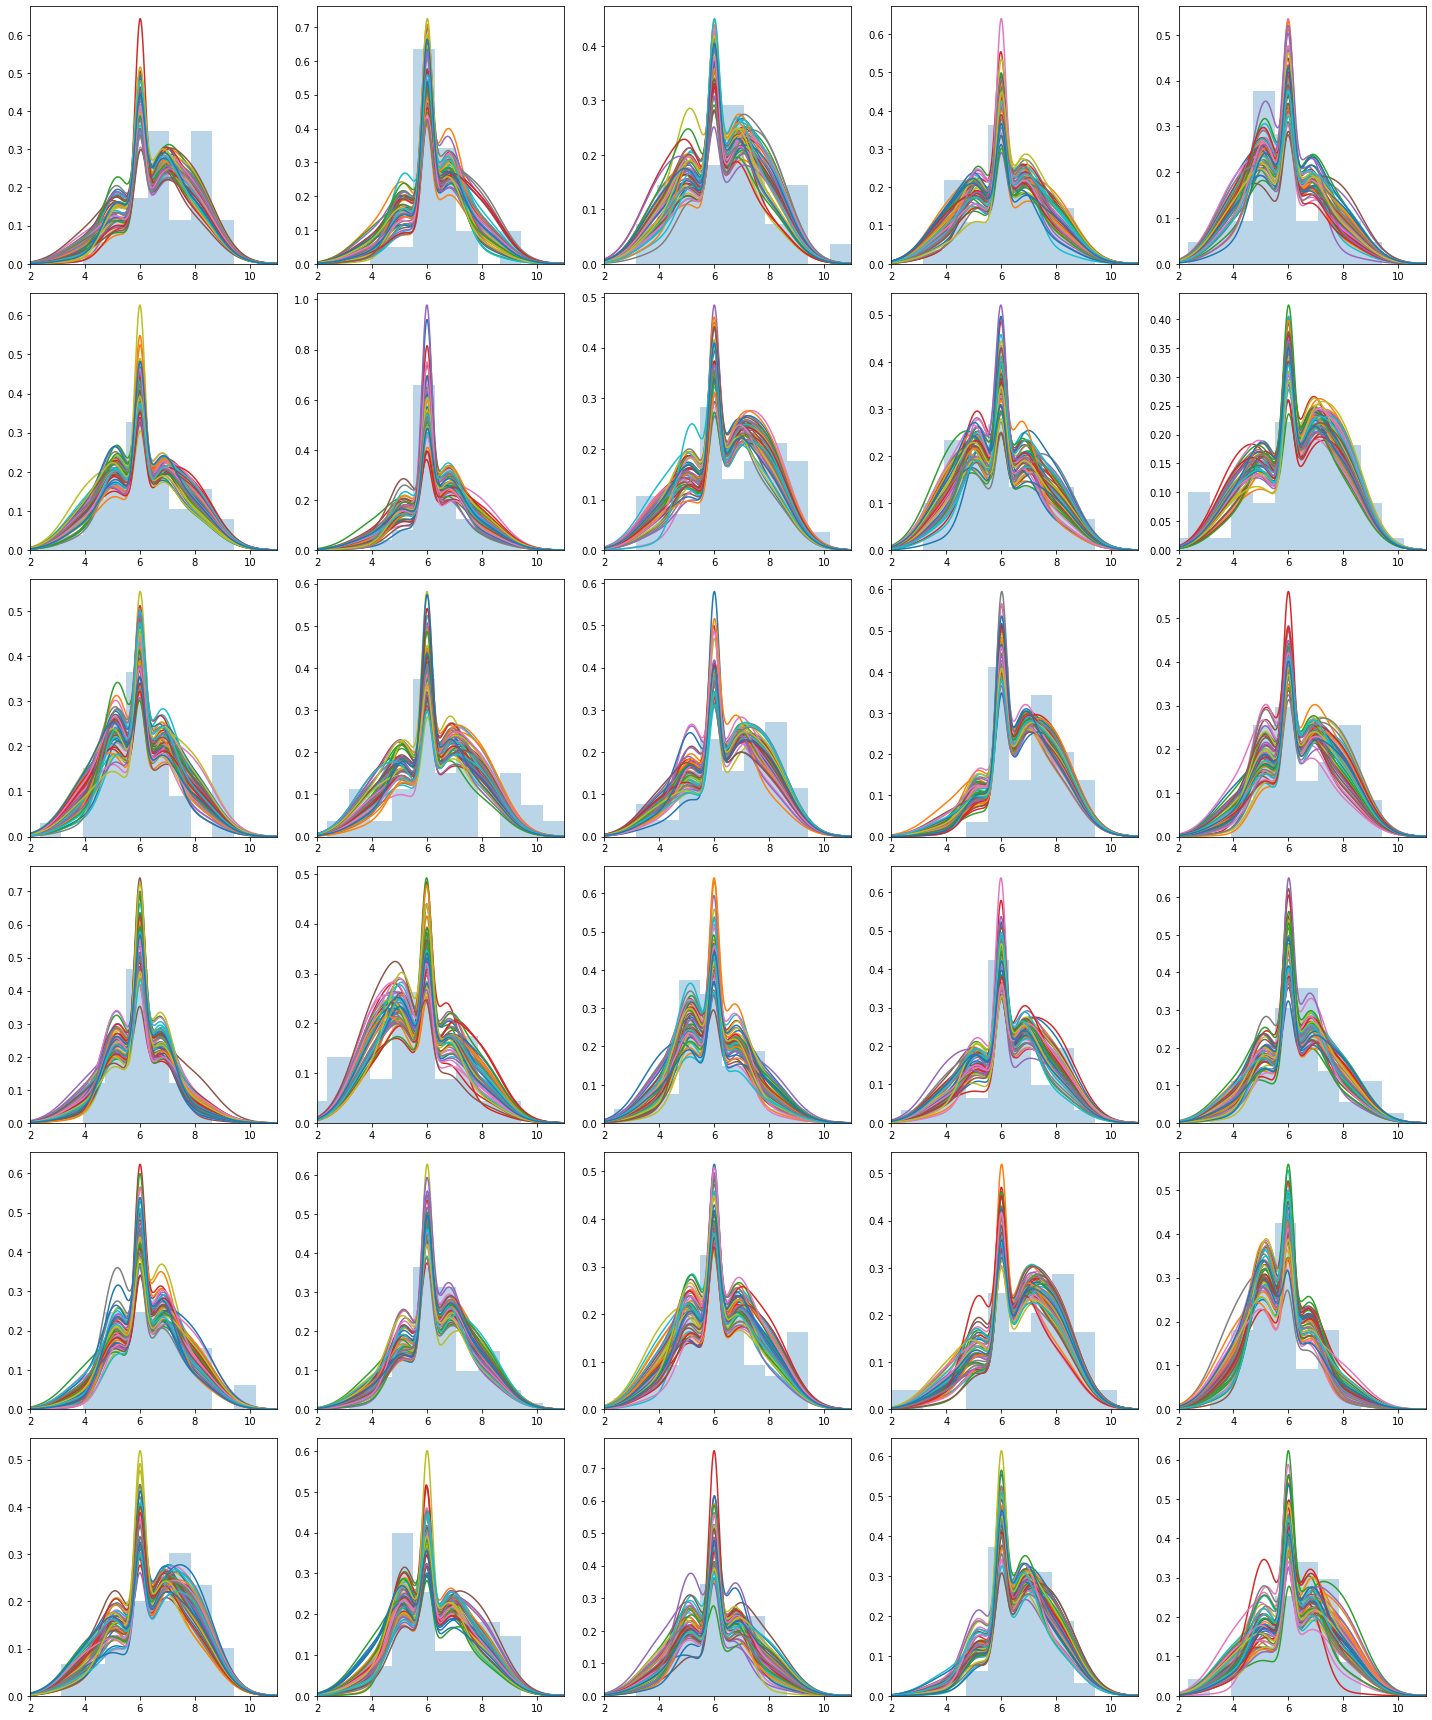

In [73]:
xgrid = np.linspace(2, 11, 1000)

toshow = list(range(30))
ncols = 5
nrows = int(len(toshow) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))
axes = axes.flat

idx = np.arange(1, len(states), 100)

for i in toshow:
    axes[i].hist(data[i, :], density=True, alpha=0.3, bins=np.linspace(0, 11, 15))

for j in sorted(idx):
    state = states[j]
    dens = eval_densities(xgrid, state.lam, state.m, state.j, state.atoms)
    for i in toshow:
        axes[i].plot(xgrid, dens[i, :], label="j: {0}".format(len(states) + j))
        axes[i].set_xlim(2, 11)
        
#axes[0].legend(fontsize=12)   
plt.tight_layout()
plt.savefig("invalsi/dens_estimate.pdf", bbox_inches="tight")        
plt.show()

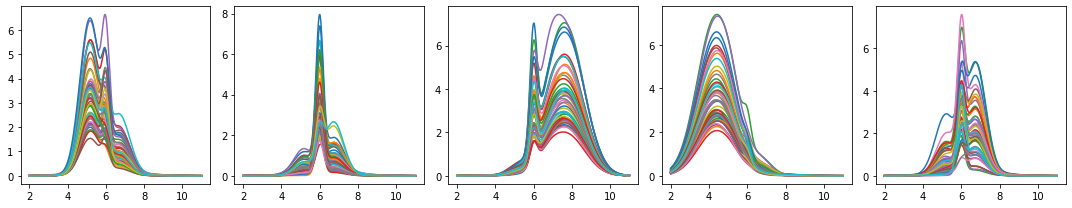

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(15, 3))

for j in sorted(idx):
    state = states[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T    


    for i in range(nlat):
        axes[i].plot(xgrid, dens_lat[i, :], label="j: {0}".format(len(states) + j))
        
#axes[0].legend(fontsize=12)

plt.tight_layout()

plt.savefig("invalsi/latent_dens.pdf", bbox_inches="tight")        
plt.show()

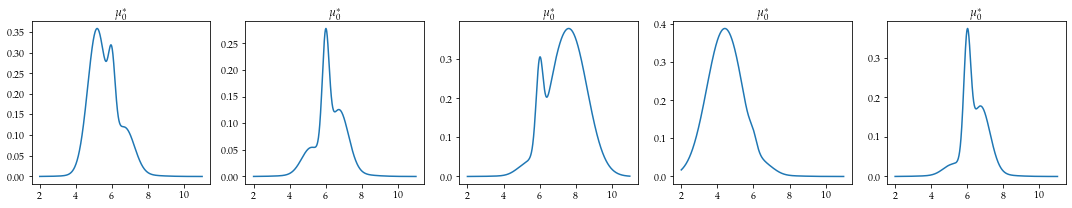

In [177]:
avg_lat_dens = np.zeros((nlat, len(xgrid)))

for state in states[-500:]:
    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T  
    avg_lat_dens += dens_lat

avg_lat_dens /= len(states)

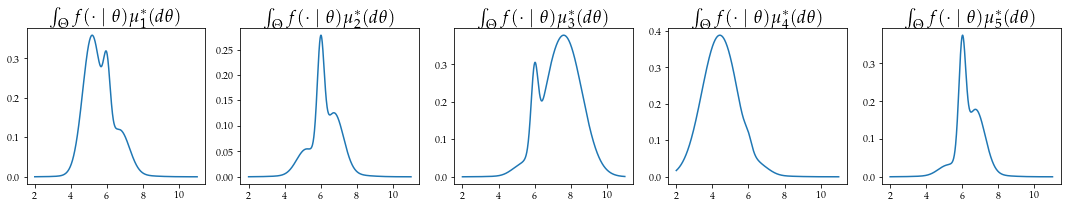

In [189]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(15, 3))


for i in range(nlat):
    axes[i].plot(xgrid, avg_lat_dens[i, :], label="j: {0}".format(len(states) + j))
    axes[i].set_title(r"$\int_\Theta f(\cdot \mid \theta )\mu^*_{0}(d\theta)$".format(i+1), fontsize=18)
        
#axes[0].legend(fontsize=12)

plt.tight_layout()

plt.savefig("invalsi/avg_latent_dens.pdf", bbox_inches="tight")        
plt.show()

In [42]:
import matplotlib.colors as colors
import numpy as onp

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return onp.ma.masked_array(onp.interp(value, x, y), onp.isnan(value))

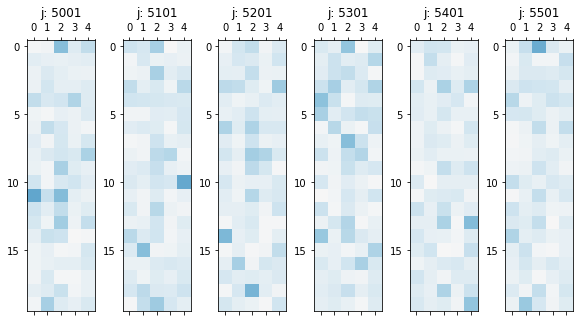

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 5))

idx = sorted(idx)

lambs = np.array([states[i].lam[:20, :] for i in idx])
vmax = np.max(lambs)

for i in range(len(idx))[:6]:
    lam = lambs[i]
    im = axes[i].matshow(lam, cmap="RdBu", 
                         clim=(-10, np.max(lambs)), 
                         norm=MidpointNormalize(midpoint=0,vmin=-1, vmax=vmax))
    axes[i].set_title("j: {0}".format(len(states) + idx[i]))


plt.savefig("invalsi/lambdas.pdf", bbox_inches="tight")

plt.show()

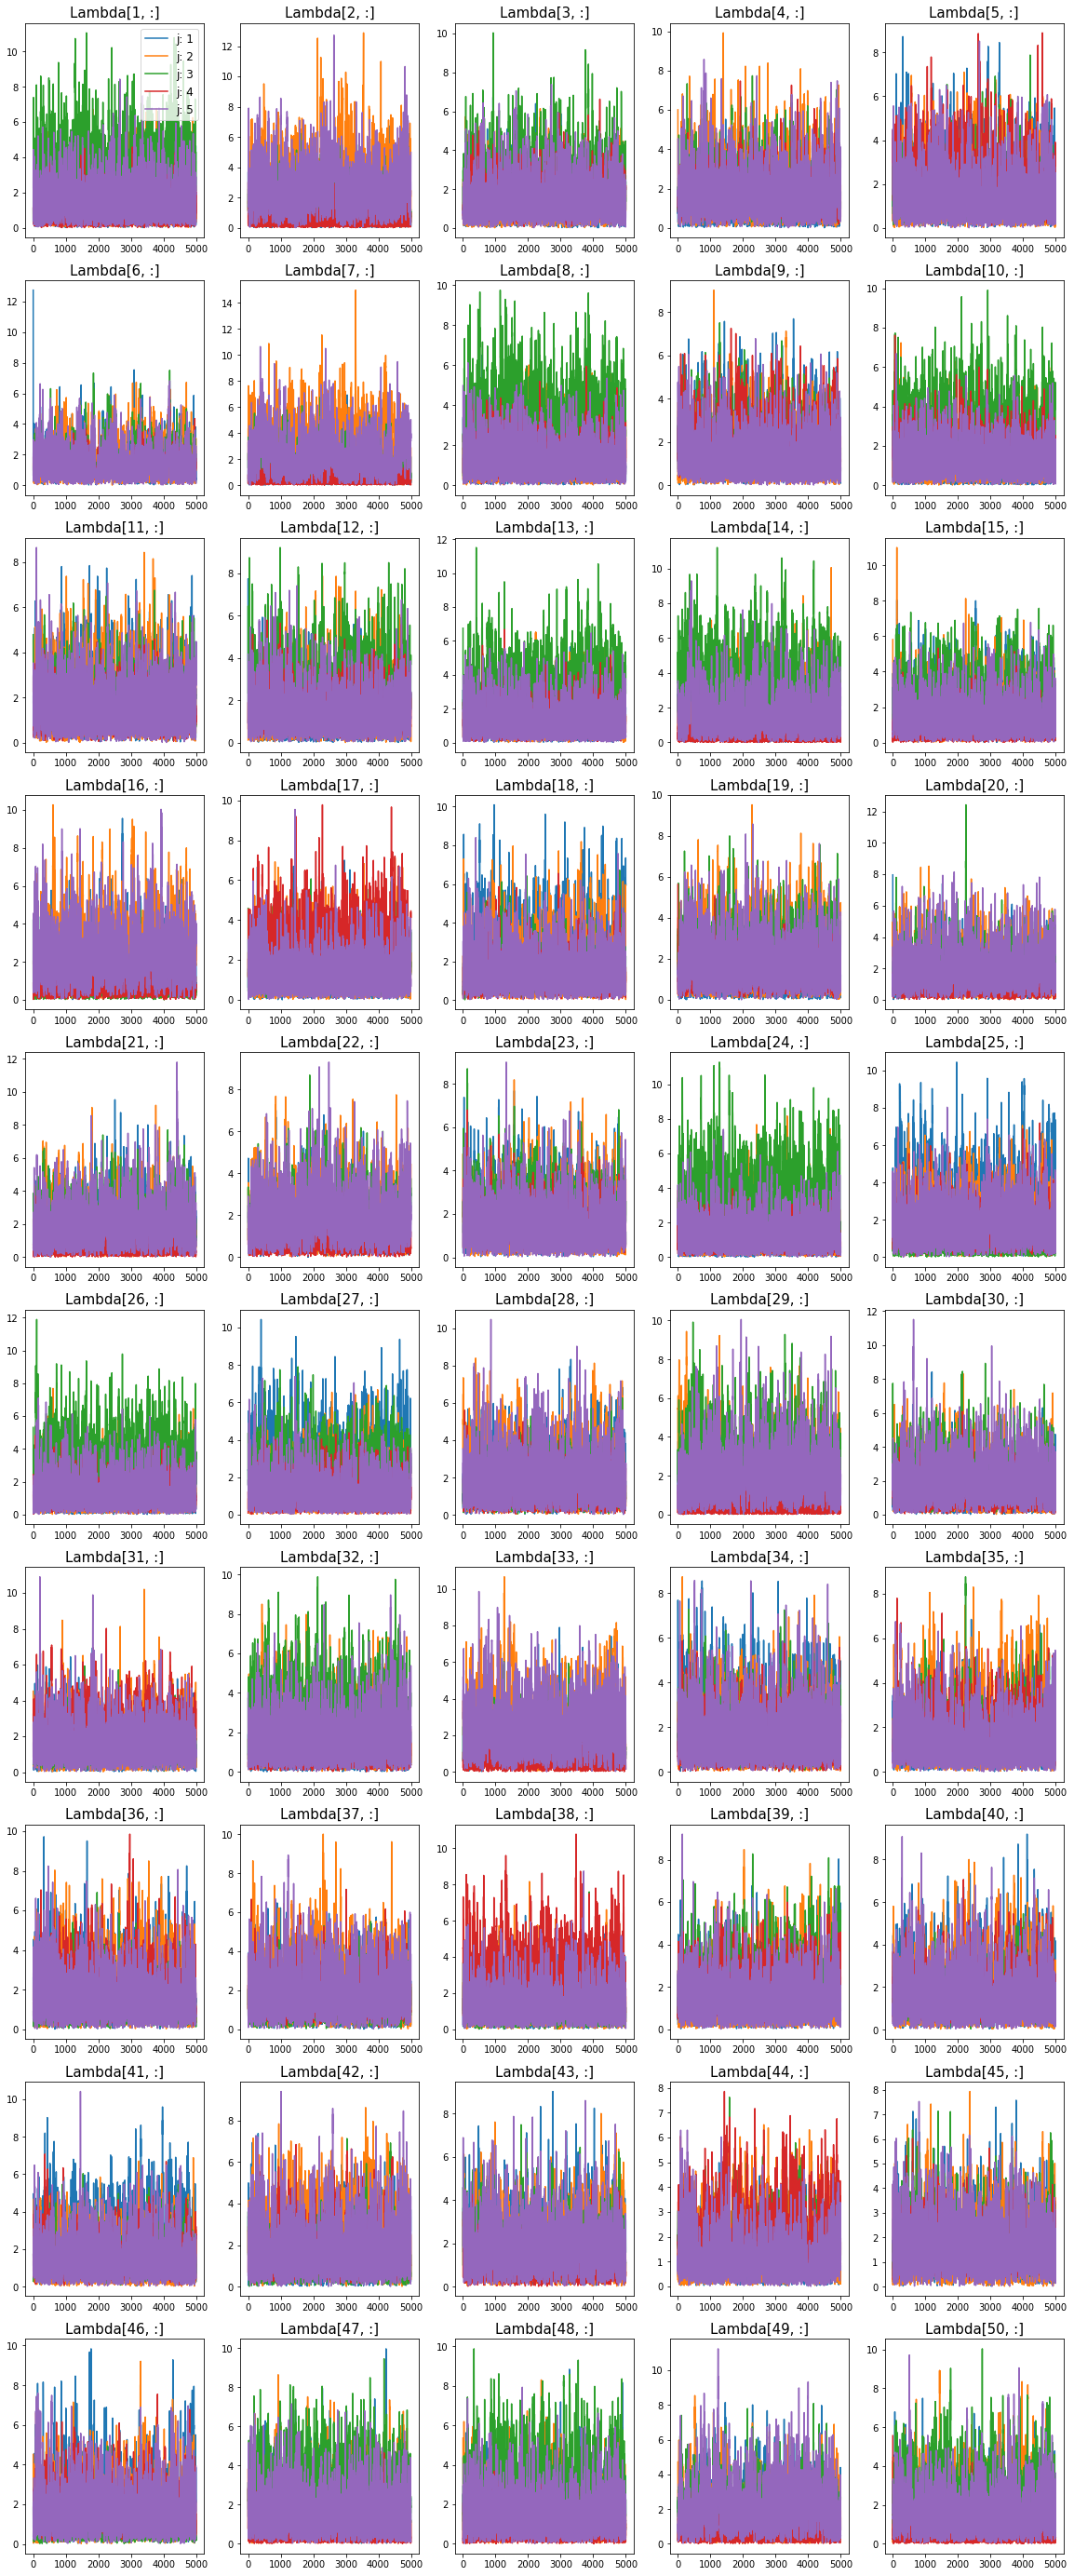

In [44]:
toshow = list(range(50))
ncols = 5
nrows = int(len(toshow) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flat

for i in toshow:
    for j in range(nlat):
        axes[i].plot([x.lam[i, j] for x in states], label="j: {0}".format(j + 1))
    
    axes[i].set_title("Lambda[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

In [45]:
# Postprocess

M = states[-1].m
lam = states[-1].m

component_dens = np.array([
    tfd.Normal(x[0], np.sqrt(x[1])).prob(xgrid) for x in states[-1].atoms])
delta = xgrid[1] - xgrid[0]


def obj_func(x):
    curr_m = x @ M
    trans_dens = curr_m @ component_dens
    trans_dens /= (np.sum(trans_dens, axis=1, keepdims=True) * delta)
    out = 0.0
    for i in range(trans_dens.shape[0]):
        for j in range(i):
            curr = (np.sum((trans_dens[i, :] * trans_dens[j, :])) * delta)**2  
            out += curr
            # print("i: {0}, j: {1}, curr: {2}".format(i, j, curr))
    return out


def constraints(x):
    return - np.concatenate([
        (lam @ np.linalg.inv(x)).reshape(-1, 1),
        (x @ M).reshape(-1, 1)])[:, 0]

def max0(x):
    return x * (x > 0)

def penalty(x, lambdas):
    return 0.5 * 1.0 * np.sum(max0(lambdas / 0.5 + constraints(x))**2)

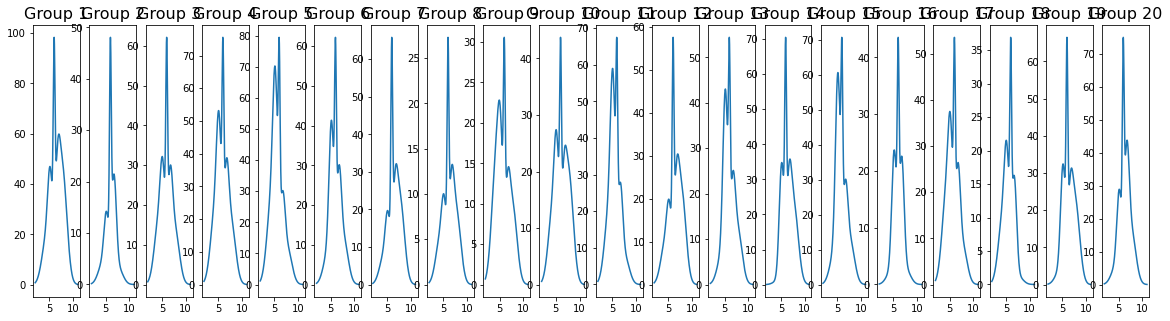

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=lam.shape[0], figsize=(20, 5))


for i in range(lam.shape[0]):
    axes[i].plot(xgrid,  lam[i, :] @ (M @ component_dens))
    axes[i].set_title("Group {0}".format(i+1), fontsize=16)


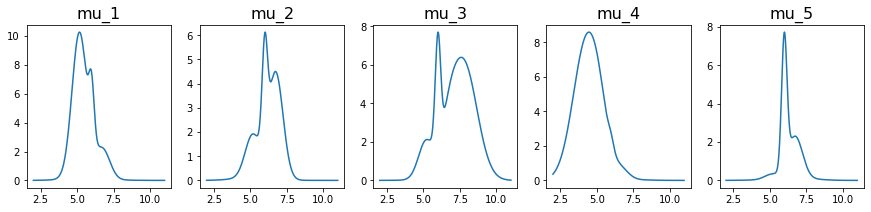

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

for j in range(M.shape[0]):
    axes[j].plot(xgrid,  (M @ component_dens)[j, :])
    axes[j].set_title("mu_{0}".format(j+1), fontsize=16)
    
    
plt.savefig("invalsi/avg_mu.pdf", bbox_inches="tight")

In [48]:
from jax import grad


grad_f = grad(obj_func)
f = obj_func

In [49]:
from nrmifactors.postprocess import dissipative_lie_rattle_fast

x0 = np.eye(M.shape[0])
opt_x, niter = dissipative_lie_rattle_fast(f, grad_f, x0, 0.9, 1e-5, 1e-6, maxiter=1000)
opt_x

DeviceArray([[ 0.78604148, -0.09824222,  0.70928829,  0.40671417,
              -0.11413097],
             [-0.29869258,  1.07992347, -0.05126601,  0.10586642,
              -0.77897977],
             [-0.03041086, -0.66808612,  0.63529089,  0.00980986,
              -0.45324753],
             [-0.14597672, -0.57159137, -0.27938304,  0.84488963,
              -0.3762951 ],
             [-0.30183986, -0.606286  ,  0.07784005,  0.24285146,
               1.00192204]], dtype=float64)

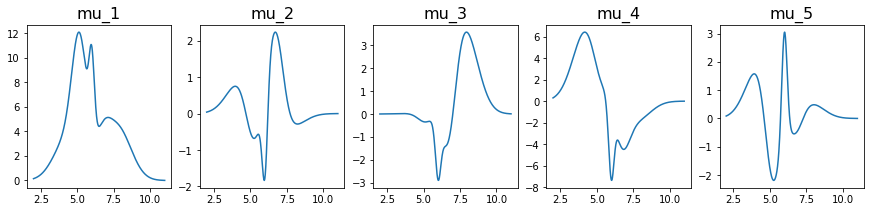

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

q = opt_x

for j in range(M.shape[0]):
    axes[j].plot(xgrid,  (q @ M @ component_dens)[j, :])
    axes[j].set_title("mu_{0}".format(j+1), fontsize=16)
    
plt.savefig("invalsi/opt_mu_unc.pdf", bbox_inches="tight")

In [87]:
from jax import jacfwd
from nrmifactors.postprocess import ralm

constr_eval = constraints(x0)
grad_cons = jacfwd(constraints)

mu = 0.9
stepsize = 1e-6
init_thr = 1e-2
target_thr = 1e-6
min_lambda = 1e-4
init_lambdas = np.zeros_like(constr_eval) + 10
max_lambda = 1000
init_rho = 10
dmin = 1e-6


opt_x_pen = ralm(
    obj_func, grad_f, constraints, grad_cons, opt_x, mu, stepsize, 
    init_thr, target_thr, init_lambdas, min_lambda, max_lambda, 
    init_rho, dmin, maxiter=10)

Init Loss:  2.3773162566908545e-14
Loss: 0.3934206470209566, step: 49.750106158274335, eps: 0.01
max(lambdas) :  80.99358915721817
Loss: 1.1055297494427228, step: 2.2850616814458915, eps: 0.009000000000000001
max(lambdas) :  128.93558644198788
Loss: 0.25493944184676776, step: 2.0460839407207065, eps: 0.008100000000000001
max(lambdas) :  128.94243122145159
Loss: 0.2677513709840122, step: 0.7213924141069872, eps: 0.007290000000000001
max(lambdas) :  128.9658200649649
Loss: 0.2736028086942034, step: 0.24110693590058008, eps: 0.006561000000000002
max(lambdas) :  128.98979975622012
Loss: 0.2783490060557067, step: 0.14561107085253677, eps: 0.005904900000000002
max(lambdas) :  129.0130406038974
Loss: 0.28341051471916734, step: 0.11928513674297589, eps: 0.005314410000000002
max(lambdas) :  129.03603529445215
Loss: 0.288193323718702, step: 0.12170982371776738, eps: 0.004782969000000002
max(lambdas) :  129.06123872537572
Loss: 0.291923621532312, step: 0.12305521106680883, eps: 0.0043046721000000

In [88]:
opt_x_pen

DeviceArray([[ 2.06182713e-01,  8.84717409e-02,  5.36314888e-02,
              -2.22782928e-02,  6.51924118e-02],
             [-4.10433052e-01,  2.30803732e+00,  1.78460655e-01,
              -1.32718572e-02, -1.25730801e+00],
             [-3.00294927e-01,  9.55000015e-02,  1.61322346e+00,
               2.22825402e-03, -7.92272665e-01],
             [-9.24605923e-03, -6.85663033e-02, -2.72451429e-03,
               8.78738784e-01, -3.02981705e-02],
             [ 8.85027163e-02, -9.59591839e-01,  3.60992748e-02,
               2.53444413e-01,  1.75780987e+00]], dtype=float64)

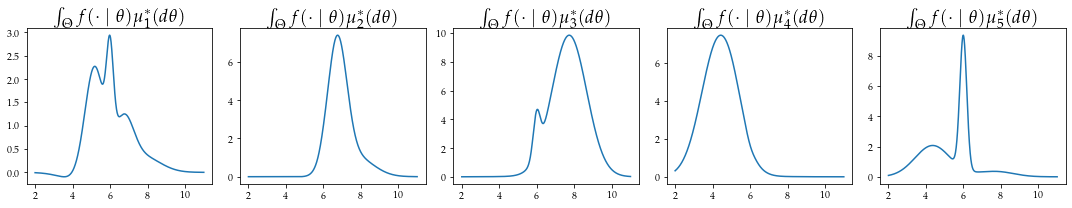

In [190]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

q = opt_x_pen

for j in range(M.shape[0]):
    axes[j].plot(xgrid,  (q @ M @ component_dens)[j, :])
    axes[j].set_title(r"$\int_\Theta f(\cdot \mid \theta )\mu^*_{0}(d\theta)$".format(j+1), fontsize=18)

plt.tight_layout()


plt.savefig("invalsi/opt_mu_con.pdf", bbox_inches="tight")
plt.show()

In [96]:
lam = states[-1].lam

In [97]:
post_lam = lam @ np.linalg.inv(opt_x_pen)

In [98]:
masses = np.sum(q @ M @ component_dens * delta, axis=1)

In [100]:
lambda_trans = post_lam * masses
lambda_trans /= np.sum(lambda_trans, axis=1,keepdims=True)

In [102]:
np.sum(lambda_trans, axis=0)

DeviceArray([479.71252908, 102.90425942,  94.23933215, 231.53018236,
             139.613697  ], dtype=float64)

# cluster based on the factor scores

In [112]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as onp


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = onp.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [130]:
model = AgglomerativeClustering(linkage="complete", distance_threshold=0, n_clusters=None)

X = onp.array(lambda_trans)
model.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

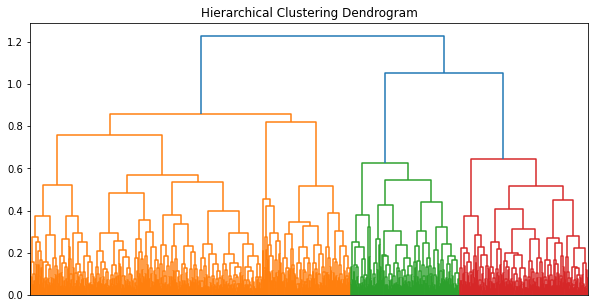

In [134]:
fig = plt.figure(figsize=(10, 5))

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level")
plt.xticks([])
plt.savefig("hclust_complete.pdf", bbox_inches="tight")
plt.show()

In [147]:
from scipy import cluster

X = onp.array(lambda_trans)
Z = cluster.hierarchy.complete(X)
cutree = cluster.hierarchy.cut_tree(Z, height=0.75)[:, 0]

DeviceArray([0, 1, 2, 3, 4, 5], dtype=int64)

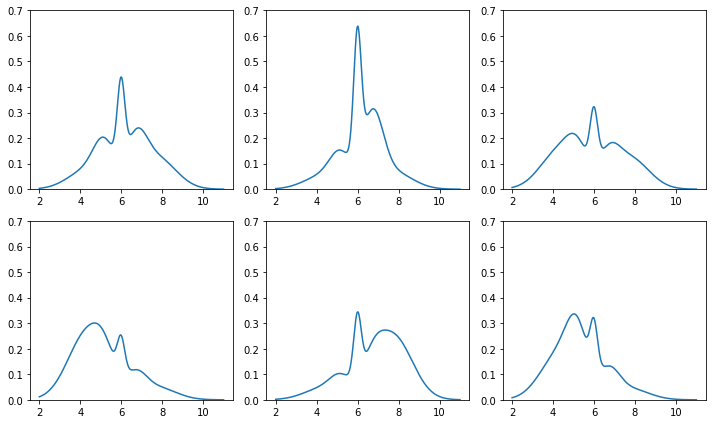

In [171]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flat

latent_dens = q @ M @ component_dens

for l in np.unique(cutree):
    idxs = np.where(cutree == l)[0]
    avg_lam = np.mean(lambda_trans[idxs, :], axis=0)
    dens = avg_lam @ latent_dens
    dens /= np.sum(dens * delta)
    axes[l].plot(xgrid, dens)
    axes[l].set_ylim(0, 0.7)
    
plt.tight_layout()
plt.savefig("cluster_dens.pdf")